In [33]:
import sys
import os
sys.path.append("..")

import jax
jax.config.update("jax_enable_x64", True)
import equinox as eqx
import jax.numpy as jnp
from jax import vmap
import jax_dataloader as jdl
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard
import argparse
from optax.contrib import reduce_on_plateau
import matplotlib.pyplot as plt
from traditional_solvers import Dx

In [1]:
import sys
import os
sys.path.append(os.path.normpath(".."))

import jax
jax.config.update("jax_enable_x64", True)
import equinox as eqx
import jax.numpy as jnp
from jax import vmap
import jax_dataloader as jdl
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard
import argparse
from optax.contrib import reduce_on_plateau

problem = "advection"
network = "fno2d"
running_on = "local"
load_path = r"C:\Users\eirik\orbax\fno2d_advection"
num_epochs = 0

if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/"
    optuna_path = ""
elif running_on == "idun":
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/"
    optuna_path = "phlearn-summer24/eirik_prosjektoppgave/"
else:
    raise ValueError("Invalid running_on")

if problem == "advection":
    data = jnp.load(data_path + "advection.npz")
elif problem == "kdv":
    data = jnp.load(data_path + "kdv.npz")
else:
    raise ValueError("Invalid problem")

# SPLIT DATA
train_val_test = train_val_test_split(jnp.array(data['data']), 0.8, 0.1, 0.1)

# SCALE DATA
scaled_data = scale_data(jnp.array(data['x']), jnp.array(data['t']), train_val_test)

a_train_s = scaled_data["a_train_s"]
u_train_s = scaled_data["u_train_s"]
a_val_s = scaled_data["a_val_s"]
u_val_s = scaled_data["u_val_s"]

x_train_s = scaled_data["x_train_s"]
t_train_s = scaled_data["t_train_s"]

# DATALOADERS
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_s, u_train_s, asnumpy = False), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_s, u_val_s, asnumpy = False), batch_size=16, shuffle=True, backend='jax', drop_last=True)

# AUTOPARALLELISM
sharding_a, sharding_u, replicated = create_device_mesh()

if network == "deeponet":
    from networks.deeponet import *
    from networks.deeponet import DeepONet as Network
    # SET PARAMETERS
    P = (x_train_s[-1]-x_train_s[0]).item() # Period
    NUMBER_OF_SENSORS = 64
    kwargs = {"number_of_sensors" : NUMBER_OF_SENSORS, "period" : P}
    Trainer.compute_loss = staticmethod(compute_loss)
elif network == "modified_deeponet":
    from networks.modified_deeponet import *
    from networks.modified_deeponet import ModifiedDeepONet as Network
    # SET PARAMETERS
    P = (x_train_s[-1]-x_train_s[0]).item() # Period
    NUMBER_OF_SENSORS = 64
    kwargs = {"period" : P}
    Trainer.compute_loss = staticmethod(compute_loss)
elif network == "fno1d":
    from networks.fno1d import FNO1d as Network
    from networks.fno1d import *
    kwargs = {}
    Trainer.compute_loss = staticmethod(compute_loss)
elif network == "fno2d":
    from networks.fno2d import FNO2d as Network
    from networks.fno2d import *
    kwargs = {}
    Trainer.compute_loss = staticmethod(compute_loss)
else:
    raise ValueError("Invalid network")

Only one device detected. Disabling array sharding and autoparallelism.


In [2]:
fno2d_trainer = Trainer.from_checkpoint(load_path, FNO2d)
fno2d_model = fno2d_trainer.model

# Using autograd jacobian to compute derivative
Test problem:

$$
u(x,t) = \sin(\pi x)
$$

Analytical derivative is

$$
u_x(x,t) = \pi \cos(\pi x)
$$

In [193]:
u = lambda x : jnp.sin(jnp.pi*x*jnp.ones_like(t_train_s[:,None]))

# we have to compute jacobian, as u_x is vector-valued
u_x = lambda x : jnp.diagonal(jax.jacfwd(u)(x), axis1=1, axis2=2)

u_x_autodiff = u_x(x_train_s)

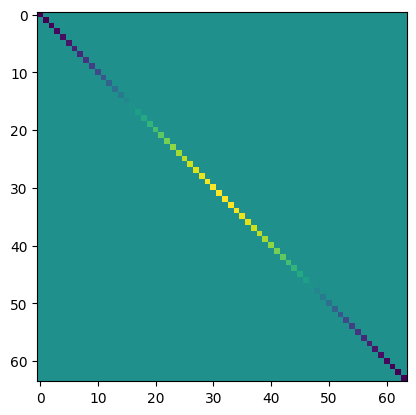

In [194]:
plt.imshow(jax.jacfwd(u)(x_train_s)[0])

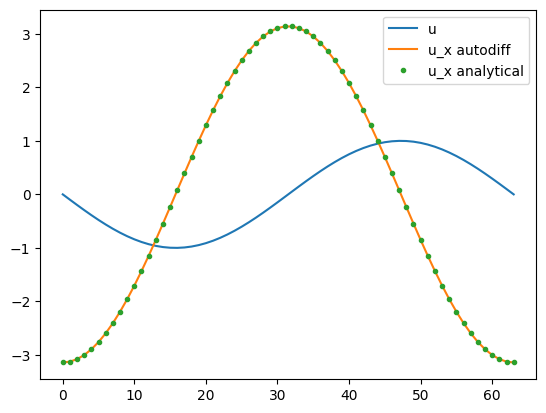

In [123]:
plt.figure()
plt.plot(u(x_train_s)[0], label="u")
plt.plot(u_x_autodiff[0], label="u_x autodiff")
plt.plot(jnp.pi*jnp.cos(jnp.pi*x_train_s*jnp.ones_like(t_train_s[:,None]))[0], ".", label="u_x analytical")
plt.legend()
plt.show()

This worked:) Now let's use the exact same approach for our FNO2d model

In [139]:
# u(x), function in x only (for convenience)
u = lambda x : fno2d_model(a_val_s[0], x, t_train_s)

# we have to compute jacobian, as u_x is vector-valued
u_x = lambda x : jnp.diagonal(jax.jacfwd(u)(x), axis1=1, axis2=2)

u_x_autodiff = u_x(x_train_s)
u_pred = u(x_train_s)

First, confirm that the model is able to predict u:

In [ ]:
def compl_mul2d(input, weights):
    # (in_channel, x, y), (in_channel, out_channel, x,y) -> (out_channel, x,y)
    return jnp.einsum("ixy,ioxy->oxy", input, weights)
    
def v_next(v):
    in_channels, points_x, points_y = v.shape

    # Fourier transform
    v_hat = jnp.fft.rfft2(v)
    
    modes1 = 8
    modes2 = 8
    
    # Multiply relevant Fourier modes
    out_hat_padded = jnp.zeros((3, points_x, points_y//2 + 1), dtype = v_hat.dtype)
    weights1 = jnp.ones((3,3, modes1, modes2)) + 1j*jnp.ones((3,3, modes1, modes2))
    weights2 = jnp.ones((3,3, modes1, modes2)) + 1j*jnp.ones((3,3, modes1, modes2))

    out_hat_padded = out_hat_padded.at[:, :modes1 , :modes2].set(compl_mul2d(v_hat[:, :modes1 , :modes2], weights1))
    out_hat_padded = out_hat_padded.at[:, -modes1:, :modes2].set(compl_mul2d(v_hat[:, -modes1: , :modes2], weights2))

    # Return to physical space
    out = jnp.fft.irfft2(out_hat_padded, s=[points_x, points_y])
    return out

v0 = jnp.ones((3, 64, 64))

jax.jacfwd(v_next)(v0).shape

(3, 64, 64)
(3, 64, 33)


(3, 64, 64, 3, 64, 64)

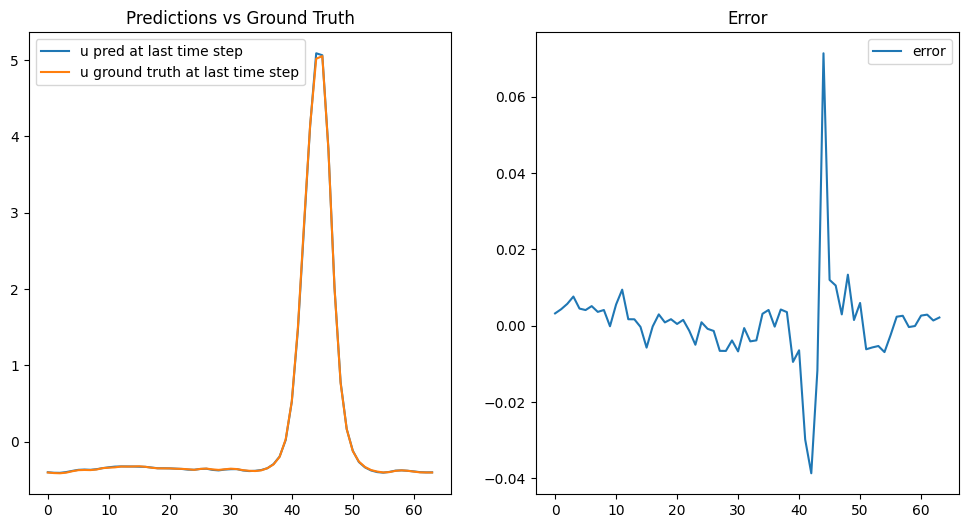

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predictions and ground truth
axes[0].plot(u_pred[-1], label="u pred at last time step")
axes[0].plot(u_val_s[0, -1], label="u ground truth at last time step")
axes[0].legend()
axes[0].set_title("Predictions vs Ground Truth")

# Plot error
axes[1].plot(u_pred[-1] - u_val_s[0, -1], label="error")
axes[1].legend()
axes[1].set_title("Error")

plt.show()

Now let's compare the autodiff of the prediction with finite differences of the prediction

In [140]:
u_x_finite_diff = Dx(u_pred[:,:-1], x_train_s[1]-x_train_s[0], axis=1, order=6)
u_x_finite_diff = jnp.concatenate((u_x_finite_diff, (u_x_finite_diff[:,0]).reshape(len(u_x_finite_diff), 1)), axis=1)

In [208]:
import torch
import jax

weight1 = torch.empty(80, 80, 8, 8, dtype=torch.cfloat)
init_std = (2 / (80 + 80))**0.5
weight1.normal_(0., init_std)
weight1 = jnp.array(weight1.numpy())


key = jax.random.PRNGKey(0)
weight = jax.random.normal(key, (80, 80, 8, 8), dtype=jnp.complex64) * init_std

print(jnp.mean(jnp.mean(weight1)))
print(jnp.mean(jnp.mean(weight)))

print(jnp.var(weight1))
print(jnp.var(weight))

(-9.626304e-05+7.246546e-05j)
(0.00013520563-4.874202e-05j)
0.012506846
0.012536916


(64, 128)
5.639638572752531e-15
9.588915447732569e-15


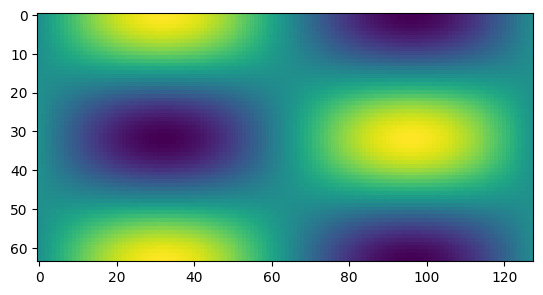

In [ ]:
import jax.numpy as jnp
import numpy as np

# Define grid parameters
Nx, Nt = 128, 64  # Grid size (spatial and temporal)
Lx, Lt = 10.0, 5.0  # Domain lengths (spatial and temporal)

dx, dt = Lx / Nx, Lt / Nt  # Grid spacing

# Generate spatial and temporal grids
x = jnp.linspace(0, Lx, Nx, endpoint=False)
t = jnp.linspace(0, Lt, Nt, endpoint=False)

# Example function: f(t, x) = sin(2πx/Lx) * cos(2πt/Lt)
f = jnp.sin(2 * jnp.pi * x / Lx) * jnp.cos(2 * jnp.pi * t[:, None] / Lt)

# Compute 2D Fourier transform (real-to-complex)
F_ft = jnp.fft.rfft2(f)

# Generate frequencies
kt = jnp.fft.fftfreq(Nt, dt) * 2 * jnp.pi 
kx = jnp.fft.rfftfreq(Nx, dx) * 2 * jnp.pi

kt_grid, kx_grid = jnp.meshgrid(kt, kx, indexing="ij")

# Apply differentiation in Fourier space
# ∂f/∂t -> Multiply by i*omega
df_dt_ft = 1j * kt_grid * F_ft

# ∂f/∂x -> Multiply by i*kx
df_dx_ft = 1j * kx_grid * F_ft

# Transform back to physical space
df_dt = jnp.fft.irfft2(df_dt_ft, s=(Nt, Nx))
df_dx = jnp.fft.irfft2(df_dx_ft, s=(Nt, Nx))

# Verification: Check the result against analytical derivatives
df_dt_exact = -(2 * jnp.pi / Lt) * jnp.sin(2 * jnp.pi * x / Lx) * jnp.sin(2 * jnp.pi * t[:, None] / Lt)
df_dx_exact = (2 * jnp.pi / Lx) * jnp.cos(2 * jnp.pi * x / Lx) * jnp.cos(2 * jnp.pi * t[:, None] / Lt)

# Error
error_dt = jnp.linalg.norm(df_dt - df_dt_exact) / jnp.linalg.norm(df_dt_exact)
error_dx = jnp.linalg.norm(df_dx - df_dx_exact) / jnp.linalg.norm(df_dx_exact)

print(f.shape)
plt.imshow(f)
print(error_dt)
print(error_dx)

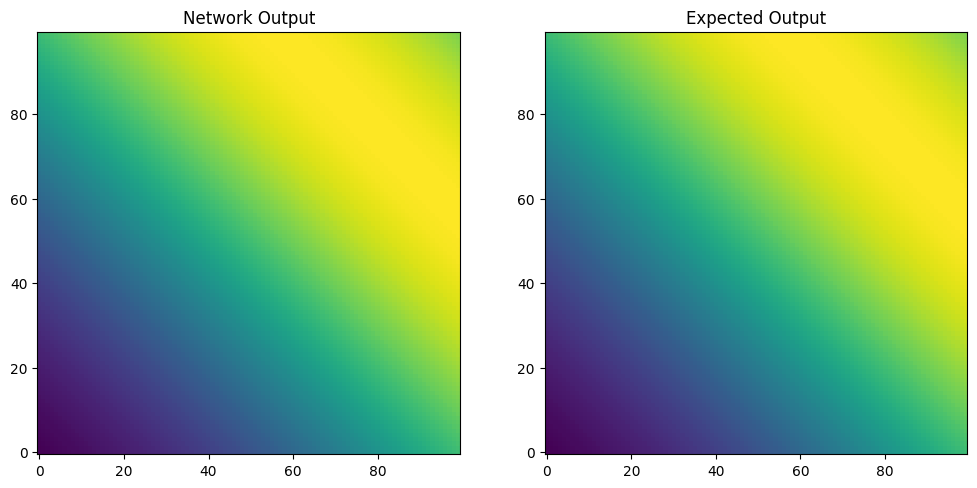

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define v(x)
def v(x, t):
    return x + t[:,None]

# Custom f(v)
@jax.custom_vjp
def f(v):
    return jnp.sin(v)

# Define df/dx as a function of v only
def df_dx(v):
    return jnp.cos(v)
    
def df_dt(v):
    return jnp.cos(v)

# Custom VJP for f(v)
def f_fwd(v):
    f_val = f(v)
    return f_val, v  # Forward pass returns f(v) and v for backward pass

def f_bwd(aux, g):
    v_val = aux  # v is the input to f
    df_dx_val = df_dx(v_val)  # Use your custom df/dx(v)
    df_dt_val = df_dt(v_val)
    return (g * df_dx_val, g * df_dt_val)  # Chain rule for f(v)

# Register the custom VJP
f.defvjp(f_fwd, f_bwd)

# Define S and Q
def S(f):
    return jnp.exp(f)

def Q(s):
    return s**2

# Full network
def network(x, t):
    v_val = v(x, t)  # Compute v(x)
    f_val = f(v_val)  # Use f(v) with custom derivative
    s_val = S(f_val)
    q_val = Q(s_val)
    return q_val

# Compute gradients
x = jnp.linspace(0, 1, 100)
t = jnp.linspace(0, 1, 100)

output = network(x, t)

def Q_x_analytic(x,t):
    return 2*(jnp.exp(jnp.sin(t + x))**2*jnp.cos(t + x))

def Q_t_analytic(x,t):
    return 2*(jnp.exp(jnp.sin(t + x))**2*jnp.cos(t + x))
    
plt.figure(figsize=(12, 6))

# Plot the output of the network
plt.subplot(1, 2, 1)
plt.imshow(output, origin="lower")
plt.title("Network Output")

# Plot the expected output
plt.subplot(1, 2, 2)
plt.imshow(jnp.exp(jnp.sin(t[:, None] + x))**2, origin="lower")
plt.title("Expected Output")

plt.show()

In [20]:
import sys
sys.path.append("..")
from traditional_solvers import Dx

# CUSTOM CHAIN RULE AUTODIFF

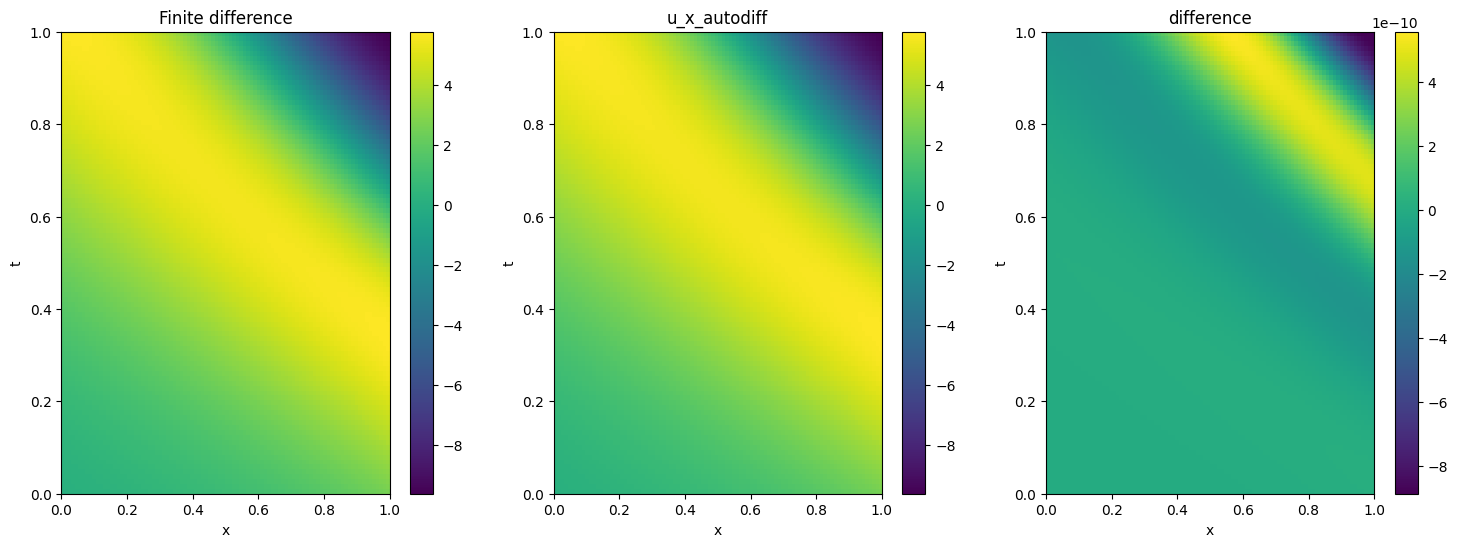

In [36]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


# Define v(x, t)
def v(x, t):
    return 1/3*x**2 + x*t[:, None] + t[:, None]  # Add a new axis to t, making it 2D to match the shape of x

def f(v_val):
    return jnp.sin(v_val) 

# Define df/dx and df/dt directly as a function of v
def df_dx(v_val):
    return jnp.cos(v_val)*(2/3*x + t[:,None])  # Derivative of sin(v) w.r.t x

def df_dt(v_val):
    return jnp.cos(v_val)*(x + jnp.ones_like(t)[:,None])   # Derivative of sin(v) w.r.t t

# Define S and Q
def S(f):
    return jnp.exp(f)

def Q(s):
    return s**2


# Full network
def network(x,t):
    v_val = v(x,t)
    f_val = f(v_val) 
    s_val = S(f_val)
    q_val = Q(s_val)
    return q_val

def dx_network(x, t):
    """
    Computes derivative of network with respect to x
    Uses custom df/dx computation at v_val
    """
    v_val = v(x, t)
    
    # Get df/dx at v_val (assuming you have this function)
    df_dx_val = df_dx(v_val)
    
    # Compute downstream derivatives using chain rule
    def downstream(f_val):
        s_val = S(f_val)
        return Q(s_val)
    f_val = f(v_val)
    
    # Get Jacobian of downstream computations
    downstream_jacobian = jax.vmap(jax.grad(downstream))(f_val.ravel()).reshape(100,100)
    
    # Combine using chain rule
    result = downstream_jacobian * df_dx_val
    return result

# Compute gradients
x = jnp.linspace(0, 1, 100)
t = jnp.linspace(0, 1, 100)

u_x_autodiff = dx_network(x, t)[3:-3,3:-3]

u_x_finite_diff = Dx(network(x, t), x[1]-x[0], axis=1, order=6)[3:-3,3:-3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Q_x_analytic
im1 = axes[0].imshow(u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x[0], x[-1], t[0], t[-1]], origin='lower')
axes[0].set_title('Finite difference')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0])

# Plot u_x_autodiff
im2 = axes[1].imshow(u_x_autodiff, aspect='auto', cmap='viridis', extent=[x[0], x[-1], t[0], t[-1]], origin='lower')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
fig.colorbar(im2, ax=axes[1])

# Plot u_x_finite_diff
im3 = axes[2].imshow(u_x_autodiff-u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x[0], x[-1], t[0], t[-1]], origin='lower')
axes[2].set_title('difference')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
fig.colorbar(im3, ax=axes[2])

plt.show()

# FNO MWE

In [128]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
from jax import random

# Define v(x, t)
def v(x, t):
    return 1/3*x**2 + x*t[:, None] + t[:, None]  # Add a new axis to t, making it 2D to match the shape of x

def f(v_val):
    return jnp.sin(v_val) 

# Define df/dx and df/dt directly as a function of v
def df_dx(v_val):
    #upstream = (2/3*x + t[:,None])
    #res = jnp.cos(v_val)*lifting(upstream.reshape(1,-1)).reshape(5,100,100)  # Derivative of sin(v) w.r.t x
    res = Dx(v_val, x[1]-x[0], axis=2, order=6)
    return res

def df_dt(v_val):
    res = jnp.cos(v_val)*(x + jnp.ones_like(t)[:,None])[None,...]   # Derivative of sin(v) w.r.t t
    return res

lifting = eqx.nn.Conv1d(in_channels = 1, out_channels = 5, kernel_size = 1, key=random.key(0))
projection = eqx.nn.Conv1d(in_channels = 5, out_channels = 1, kernel_size = 1, key=random.key(0))

# Full network
def network(x,t):
    v_val = v(x,t)[None, ...] # (1,100,100)
    lifted = lifting(v_val.reshape(1,-1)).reshape(5,100,100) # (5,100,100)
    f_val = f(lifted) 
    activation = jax.nn.gelu(f_val)
    projected = projection(activation.reshape(5,-1)).reshape(100,100) # (1,100,100)
    return projected

def dx_network(x, t):
    """
    Computes derivative of network with respect to x
    Uses custom df/dx computation at v_val
    """
    v_val = v(x, t)
    dv = jnp.cos(v_val)*(2/3*x + t[:,None])
    lifted = lifting(v_val.reshape(1,-1)).reshape(5,100,100)
    
    # Get df/dx at v_val (assuming you have this function)
    df_dx_val = df_dx(lifted)
    
    print("df_dx_val", df_dx_val.shape)
    #df_dx_val = lifting(dv.reshape(1,-1)).reshape(5,100,100)
    f_val = f(lifted)
    
    # Compute downstream derivatives using chain rule
    def downstream(f_val):
        activation = jax.nn.gelu(f_val)
        projected = projection(activation.reshape(5,1))[0,0]
        return projected
    
    # Get Jacobian of downstream computationskk
    f_val_flat = f_val.reshape(5,-1)
    downstream_jacobian = jax.vmap(jax.grad(downstream))(f_val_flat.T)
    print("downstream_jacobian", downstream_jacobian.shape)
    
    # Combine using chain rule
    #result = (downstream_jacobian.reshape(5,-1) * df_dx_val.reshape(5,-1)).sum(axis=0).reshape(100,100)
    #result = projection((downstream_jacobian.reshape(5,-1) * df_dx_val.reshape(5,-1))).reshape(100,100)
    result = jnp.tensordot(downstream_jacobian, df_dx_val.reshape(5,-1), 1).reshape(100,100)
    return result

# Compute gradients
x = jnp.linspace(0, 1, 100)
t = jnp.linspace(0, 1, 100)

result = network(x, t)

u_x_finite_diff = Dx(result, x[1]-x[0], axis=1, order=6)[3:-3,3:-3]
u_x_autodiff = dx_network(x, t)[3:-3,3:-3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Q_x_analytic
im1 = axes[0].imshow(u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x[0], x[-1], t[0], t[-1]], origin='lower')
axes[0].set_title('Finite difference')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0])

# Plot u_x_autodiff
im2 = axes[1].imshow(u_x_autodiff, aspect='auto', cmap='viridis', extent=[x[0], x[-1], t[0], t[-1]], origin='lower')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
fig.colorbar(im2, ax=axes[1])

# Plot u_x_finite_diff
im3 = axes[2].imshow(u_x_autodiff-u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x[0], x[-1], t[0], t[-1]], origin='lower')
axes[2].set_title('difference')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
fig.colorbar(im3, ax=axes[2])

plt.show()

df_dx_val (5, 100, 100)
downstream_jacobian (10000, 5)


TypeError: cannot reshape array of shape (10000, 10000) (size 100000000) into shape (100, 100) (size 10000)

# Test on 1d problem

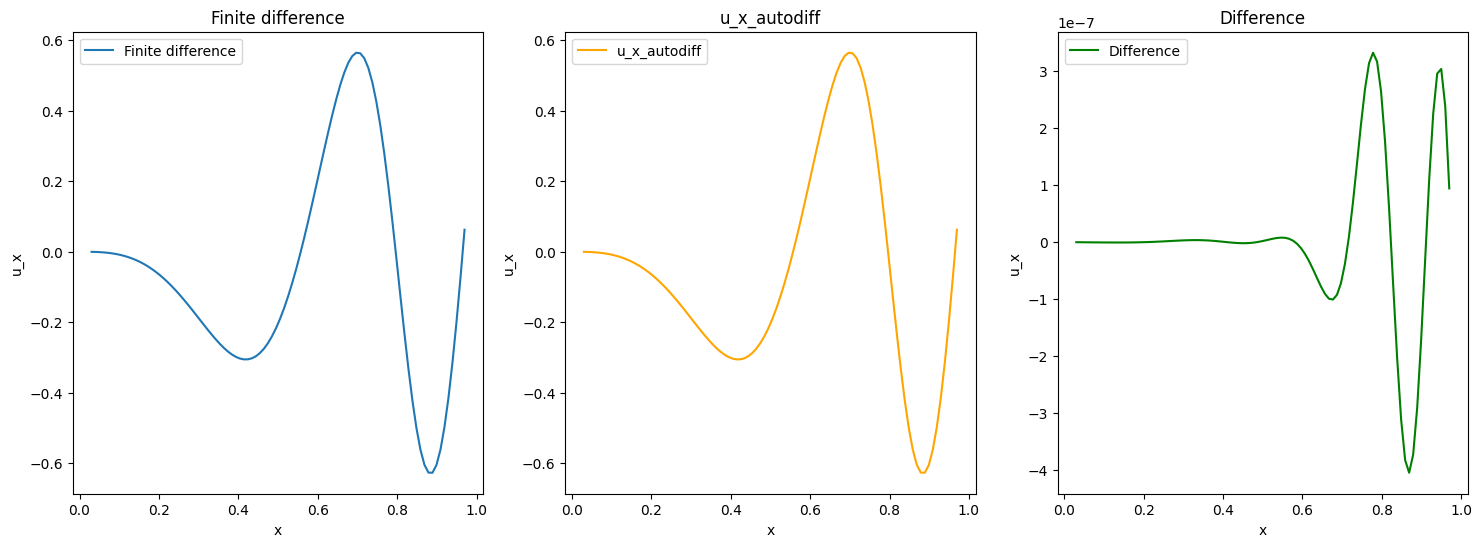

In [199]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
from jax import random
import time

hidden_channels = 5
x_points = 100
projection = eqx.nn.Conv1d(in_channels = hidden_channels, out_channels = 1, kernel_size = 1, key=random.key(0))
activation_func = lambda x : jnp.cos(x)
x = jnp.linspace(0, 1, x_points)

# Define v(x, t)
def v_Lm1(x):
    val1 = 1/3*x**2
    val2 = 2/3*x**4
    val3 = 1/5*x**3
    val4 = 1/6*x**5
    val5 = 5*x**2
    return jnp.stack([val1, val2, val3, val4, val5])
    #return jnp.stack([val1 for _ in range(hidden_channels)])

def v_L(v_Lm1_val):
    return jnp.sin(v_Lm1_val) 

def dv_L_dx(v_Lm1_val):
    dval1 = 2/3*x
    dval2 = 8/3*x**3
    dval3 = 3/5*x**2
    dval4 = 5/6*x**4
    dval5 = 10*x
    return jnp.cos(v_Lm1_val) * jnp.stack([dval1, dval2, dval3, dval4, dval5])
    
    #return jnp.cos(v_Lm1_val) * jnp.stack([dval1 for _ in range(hidden_channels)])

# Full network
def network(x):
    v_Lm1_val = v_Lm1(x) # (hidden_channels,x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,x_points)
    activation = activation_func(v_L_val) # (hidden_channels,x_points)
    projected = projection(activation)[0] # (x_points)
    return projected

"""
# old method
def dx_network(x):
    # do the start of the forward pass until the last v_L
    v_Lm1_val = v_Lm1(x) # (hidden_channels,x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,x_points)
    
    # compute derivative of Q wrt v_L
    def Q_of_v_L(v_L_val):
        activation = activation_func(v_L_val)[:,None] # (hidden_channels,1)
        projected = projection(activation) # (1,1)
        return projected[0,0] #scalar
    
    # v_L_val is (hidden_channels,x_points)
    d_Q_d_v_L = jax.vmap(jax.grad(Q_of_v_L), in_axes=1, out_axes=1)(v_L_val) # (hidden_channels, x_points)

    # compute derivative of v_L wrt x 
    d_v_L_dx = dv_L_dx(v_Lm1_val) # (hidden_channels,x_points)
    
    #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
"""
# uses sum method to compute d_Q_d_v_L
def dx_network(x):
    """
    Computes derivative of network with respect to x
    Uses custom df/dx computation at v_val
    """
    # do the start of the forward pass until the last v_L
    v_Lm1_val = v_Lm1(x) # (hidden_channels,x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,x_points)
    
    # compute derivative of Q wrt v_L
    def Q_of_v_L(v_L_val):
        activation = activation_func(v_L_val) # (hidden_channels, x_points)
        projected = projection(activation) # (hidden_channels, x_points)
        return jnp.sum(projected) #scalar
    
    # v_L_val is (hidden_channels,x_points)
    d_Q_d_v_L = jax.grad(Q_of_v_L)(v_L_val) # (hidden_channels, x_points)

    # compute derivative of v_L wrt x 
    d_v_L_dx = dv_L_dx(v_Lm1_val) # (hidden_channels,x_points)
    
    #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
    
result = network(x)

u_x_finite_diff = Dx(result, x[1]-x[0], axis=0, order=6)[3:-3]
u_x_autodiff = dx_network(x)[3:-3]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Q_x_analytic
axes[0].plot(x[3:-3], u_x_finite_diff, label='Finite difference')
axes[0].set_title('Finite difference')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u_x')
axes[0].legend()

# Plot u_x_autodiff
axes[1].plot(x[3:-3], u_x_autodiff, label='u_x_autodiff', color='orange')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('u_x')
axes[1].legend()

# Plot difference
axes[2].plot(x[3:-3], u_x_autodiff - u_x_finite_diff, label='Difference', color='green')
axes[2].set_title('Difference')
axes[2].set_xlabel('x')
axes[2].set_ylabel('u_x')
axes[2].legend()

plt.show()

# Test on 2D problem

result (64, 64)
u_x_finite_diff (64, 58)
u_x_autodiff (64, 58)


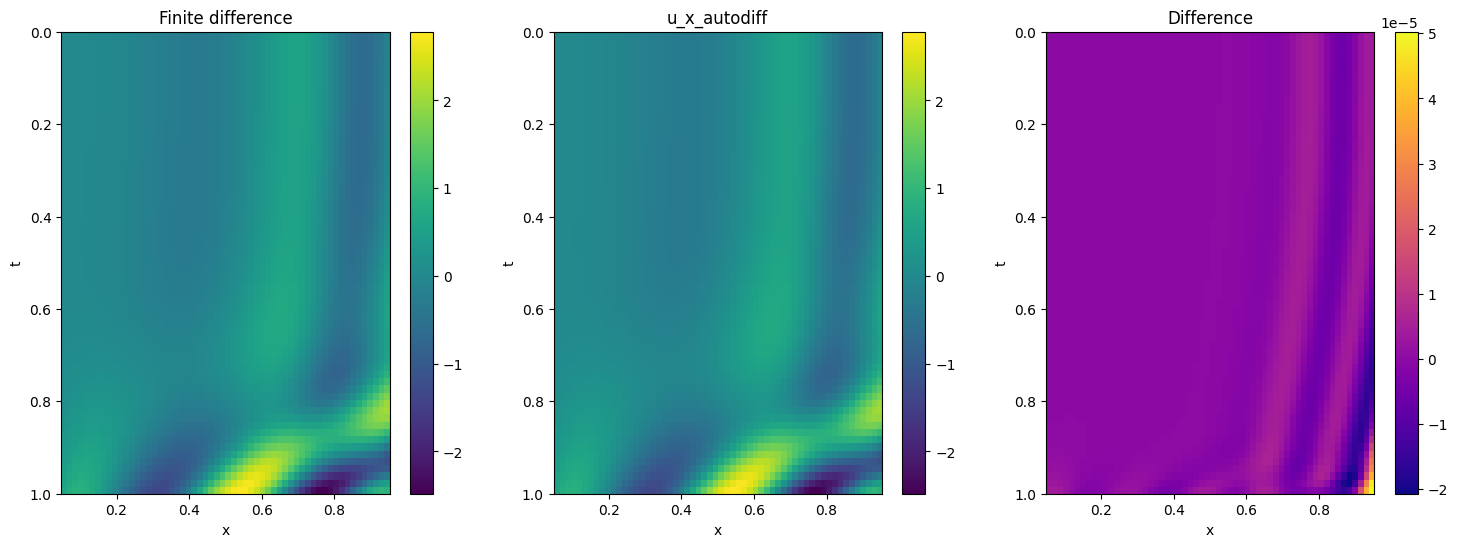

In [212]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
from jax import random
import time

hidden_channels = 5
x_points = 64
t_points = 64
projection = eqx.nn.Conv2d(in_channels = hidden_channels, out_channels = 1, kernel_size = 1, key=random.key(0))
activation_func = lambda x : jnp.cos(x)
x = jnp.linspace(0, 1, x_points)
t = jnp.linspace(0, 1, t_points)

# Define v(x, t)
def v_Lm1(x, t):
    val1 = 1/3*x**2 + 2*t[:,None]**3*x
    val2 = 2/3*x**4 + 1.6*t[:,None]**2 * x**2
    val3 = 1/5*x**3 + 4.3*t[:,None]**2.3 * x
    val4 = 1/6*x**5 + 7.2*t[:,None]**3.2 * x
    val5 = 5*x**2 + 1.52*t[:,None]**2.4 * x
    return jnp.stack([val1, val2, val3, val4, val5])
    #return jnp.stack([val1 for _ in range(hidden_channels)])

def v_L(v_Lm1_val):
    return jnp.sin(v_Lm1_val) 

def dv_L_dx(v_Lm1_val):
    dval1 = 2/3*x + 2*t[:,None]**3
    dval2 = 8/3*x**3 + 1.6*t[:,None]**2*2*x
    dval3 = 3/5*x**2 + 4.3*t[:,None]**2.3
    dval4 = 5/6*x**4 + 7.2*t[:,None]**3.2
    dval5 = 10*x + 1.52*t[:,None]**2.4
    return jnp.cos(v_Lm1_val) * jnp.stack([dval1, dval2, dval3, dval4, dval5], axis=0)
    
    #return jnp.cos(v_Lm1_val) * jnp.stack([dval1 for _ in range(hidden_channels)])

# Full network
def network(x, t):
    v_Lm1_val = v_Lm1(x, t) # (hidden_channels, t_points, x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels, t_points, x_points)
    activation = activation_func(v_L_val) # (hidden_channels,t_points, x_points)
    projected = projection(activation)[0] # (t_points, x_points)
    return projected

"""
# old method
def dx_network(x):
    # do the start of the forward pass until the last v_L
    v_Lm1_val = v_Lm1(x) # (hidden_channels,x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,x_points)
    
    # compute derivative of Q wrt v_L
    def Q_of_v_L(v_L_val):
        activation = activation_func(v_L_val)[:,None] # (hidden_channels,1)
        projected = projection(activation) # (1,1)
        return projected[0,0] #scalar
    
    # v_L_val is (hidden_channels,x_points)
    d_Q_d_v_L = jax.vmap(jax.grad(Q_of_v_L), in_axes=1, out_axes=1)(v_L_val) # (hidden_channels, x_points)

    # compute derivative of v_L wrt x 
    d_v_L_dx = dv_L_dx(v_Lm1_val) # (hidden_channels,x_points)
    
    #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
"""
# uses sum method to compute d_Q_d_v_L
def dx_network(x, t):
    """
    Computes derivative of network with respect to x
    Uses custom df/dx computation at v_val
    """
    # do the start of the forward pass until the last v_L
    v_Lm1_val = v_Lm1(x, t) # (hidden_channels,t_points, x_points)
    v_L_val = v_L(v_Lm1_val) # (hidden_channels,t_points, x_points)
    
    # compute derivative of Q wrt v_L
    def Q_of_v_L(v_L_val):
        activation = activation_func(v_L_val) # (hidden_channels, t_points, x_points)
        projected = projection(activation) # (hidden_channels, t_points, x_points)
        return jnp.sum(projected) #scalar
    
    # v_L_val is (hidden_channels,t_points, x_points)
    d_Q_d_v_L = jax.grad(Q_of_v_L)(v_L_val) # (hidden_channels, t_points, x_points)

    # compute derivative of v_L wrt x 
    d_v_L_dx = dv_L_dx(v_Lm1_val) # (hidden_channels,t_points, x_points)
    
    #return jnp.einsum('ij,ji->i', d_Q_d_v_L, d_v_L_dx)
    return (d_Q_d_v_L * d_v_L_dx).sum(axis=0)
    
result = network(x, t)

print("result", result.shape)


u_x_finite_diff = Dx(result, x[1]-x[0], axis=1, order=6)[:, 3:-3]
u_x_autodiff = dx_network(x, t)[:, 3:-3]

print("u_x_finite_diff", u_x_finite_diff.shape)
print("u_x_autodiff", u_x_autodiff.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Q_x_analytic
im1 = axes[0].imshow(u_x_finite_diff, aspect='auto', extent=[x[3], x[-4], t[-1], t[0]])
axes[0].set_title('Finite difference')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0])

# Plot u_x_autodiff
im2 = axes[1].imshow(u_x_autodiff, aspect='auto', extent=[x[3], x[-4], t[-1], t[0]], cmap='viridis')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
fig.colorbar(im2, ax=axes[1])

# Plot difference
im3 = axes[2].imshow(u_x_autodiff - u_x_finite_diff, aspect='auto', extent=[x[3], x[-4], t[-1], t[0]], cmap='plasma')
axes[2].set_title('Difference')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
fig.colorbar(im3, ax=axes[2])

plt.show()

# Implementation for the actual FNO2d

In [213]:
%timeit jax.block_until_ready(Dx(result, x[1]-x[0], axis=1, order=6)[:, 3:-3])
%timeit jax.block_until_ready(dx_network(x, t)[:, 3:-3])

1.42 ms ± 145 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
12.9 ms ± 329 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import jax
import jax.numpy as jnp

# Define v(x)
def v(x):
    return jnp.log(1 + x**2)

# Custom f(v)
@jax.custom_vjp
def f(v, x, t):
    return jnp.sin(v)

# Define df/dx as a function of v only
def df_dx(v):
    channels, Nt, Nx = v.shape

    dx = 1. / (Nx-1)

    # Compute 2D Fourier transform
    F_ft = jnp.fft.rfft2(v)

    # Generate frequencies
    kx = jnp.fft.rfftfreq(Nx, dx) * 2 * jnp.pi
    kx_grid = jnp.tile(kx, (Nt, 1))

    # Apply differentiation in Fourier space
    df_dx_ft = 1j * kx_grid * F_ft

    # Transform back to physical space
    df_dx_val = jnp.fft.irfft2(df_dx_ft, s=(Nt, Nx))
    return df_dx_val
    
def df_dt(v):
    channels, Nt, Nx = v.shape
    dt = 1. / (Nt-1)  # Grid spacing

    # Compute 2D Fourier transform
    F_ft = jnp.fft.rfft2(v)

    # Generate frequencies
    kt = jnp.fft.fftfreq(Nt, dt) * 2 * jnp.pi 
    kt_grid = jnp.tile(kt, (Nx, 1)).T

    # Apply differentiation in Fourier space
    df_dt_ft = 1j * kt_grid * F_ft

    # Transform back to physical space
    df_dt_val = jnp.fft.irfft2(df_dt_ft, s=(Nt, Nx))
    
    return df_dt_val

# Custom VJP for f(v)
def f_fwd(v, x, t):
    f_val = f(v)
    return f_val, v  # Forward pass returns f(v) and v for backward pass

def f_bwd(aux, g):
    v_val = aux  # v is the input to f
    df_dx_val = df_dx(v_val)  # Use your custom df/dx(v)
    df_dt_val = df_dt(v_val)
    return (0., g * df_dx_val, g * df_dt_val)  # Chain rule for f(v)

# Register the custom VJP
f.defvjp(f_fwd, f_bwd)

# Define S and Q
def S(f_val):
    return jnp.exp(f_val)

def Q(s_val):
    return s_val**2

# Full network
def network(x, t):
    v_val = v(x)  # Compute v(x)
    f_val = f(v_val)  # Use f(v) with custom derivative
    s_val = S(f_val)
    q_val = Q(s_val)
    return q_val

# Compute gradients
x = jnp.linspace(0, 1, 100)
t = jnp.linspace(0, 1, 100)
output = network(x, t)

# Compute gradients
dq_dx = jax.grad(network)(x)
print("Output:", output)
print("dq/dx:", dq_dx)

TypeError: network() missing 1 required positional argument: 't'

In [ ]:
import jax
import jax.numpy as jnp

# Define v(x)
def v(x):
    return jnp.log(1 + x**2)

# Custom f(v)
@jax.custom_vjp
def f(v, x, t):
    return jnp.sin(v)

# Define df/dx as a function of v only
def df_dx(v):
    channels, Nt, Nx = v.shape

    dx = 1. / (Nx-1)

    # Compute 2D Fourier transform
    F_ft = jnp.fft.rfft2(v)

    # Generate frequencies
    kx = jnp.fft.rfftfreq(Nx, dx) * 2 * jnp.pi
    kx_grid = jnp.tile(kx, (Nt, 1))

    # Apply differentiation in Fourier space
    df_dt_ft = 1j * kt_grid * F_ft
    df_dx_ft = 1j * kx_grid * F_ft

    # Transform back to physical space
    df_dx_val = jnp.fft.irfft2(df_dx_ft, s=(Nt, Nx))
    return df_dx_val
    
def df_dt(v):
    channels, Nt, Nx = v.shape
    dt = 1. / (Nt-1)  # Grid spacing

    # Compute 2D Fourier transform
    F_ft = jnp.fft.rfft2(v)

    # Generate frequencies
    kt = jnp.fft.fftfreq(Nt, dt) * 2 * jnp.pi 
    kt_grid = jnp.tile(kt, (Nx, 1)).T

    # Apply differentiation in Fourier space
    df_dt_ft = 1j * kt_grid * F_ft

    # Transform back to physical space
    df_dt_val = jnp.fft.irfft2(df_dt_ft, s=(Nt, Nx))
    
    return df_dt_val

# Custom VJP for f(v)
def f_fwd(v):
    f_val = f(v)
    return f_val, v  # Forward pass returns f(v) and v for backward pass

def f_bwd(aux, g):
    v_val = aux  # v is the input to f
    df_dx_val = df_dx(v_val)  # Use your custom df/dx(v)
    return (g * df_dx_val,)  # Chain rule for f(v)

# Register the custom VJP
f.defvjp(f_fwd, f_bwd)

# Define S and Q
def S(f_val):
    return jnp.exp(f_val)

def Q(s_val):
    return s_val**2

# Full network
def network(x):
    v_val = v(x)  # Compute v(x)
    f_val = f(v_val)  # Use f(v) with custom derivative
    s_val = S(f_val)
    q_val = Q(s_val)
    return q_val

# Compute gradients
x = jnp.array(1.0)
output = network(x)

# Compute gradients
dq_dx = jax.grad(network)(x)
print("Output:", output)
print("dq/dx:", dq_dx)

Output: 3.5891756516155984
dq/dx: 5.5218670701022035


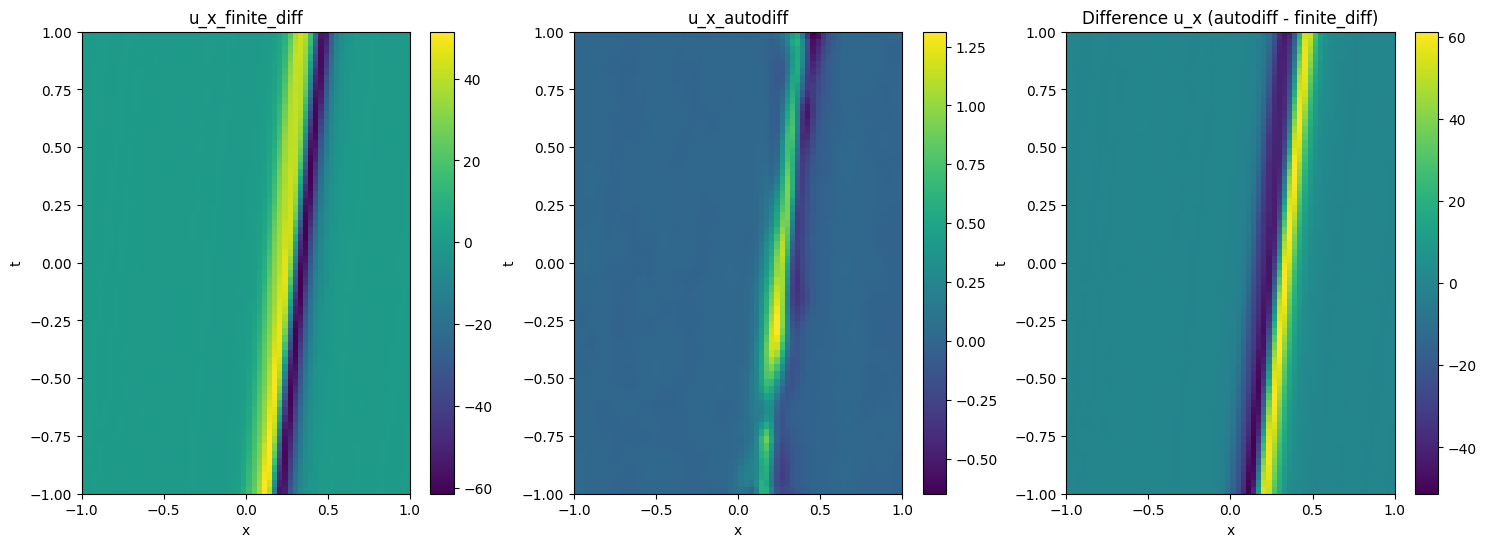

Largest difference in u_x: 61.167076551200466


In [145]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot u_x_finite_diff
im1 = axes[0].imshow(u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x_train_s[0], x_train_s[-1], t_train_s[0], t_train_s[-1]], origin='lower')
axes[0].set_title('u_x_finite_diff')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0])

# Plot u_x_autodiff
im2 = axes[1].imshow(u_x_autodiff, aspect='auto', cmap='viridis', extent=[x_train_s[0], x_train_s[-1], t_train_s[0], t_train_s[-1]], origin='lower')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
fig.colorbar(im2, ax=axes[1])

# Plot difference u_x
im3 = axes[2].imshow(u_x_autodiff - u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x_train_s[0], x_train_s[-1], t_train_s[0], t_train_s[-1]], origin='lower')
axes[2].set_title('Difference u_x (autodiff - finite_diff)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
fig.colorbar(im3, ax=axes[2])

plt.show()

print("Largest difference in u_x:", jnp.max(jnp.abs(u_x_autodiff - u_x_finite_diff)))

This does not look that good:(

In [182]:
def differentiate_rfft(u, axis):
    k = jnp.fft.rfftfreq(u.shape[axis], d=2/(u.shape[axis]-1)) 
    u_hat = jnp.fft.rfft(u, axis=axis)
    du_hat = k * 2j * jnp.pi * u_hat
    du = jnp.fft.irfft(du_hat, axis=axis, n=u.shape[axis])
    return du
u_pred_x_rfft = differentiate_rfft(u_pred, axis=1)


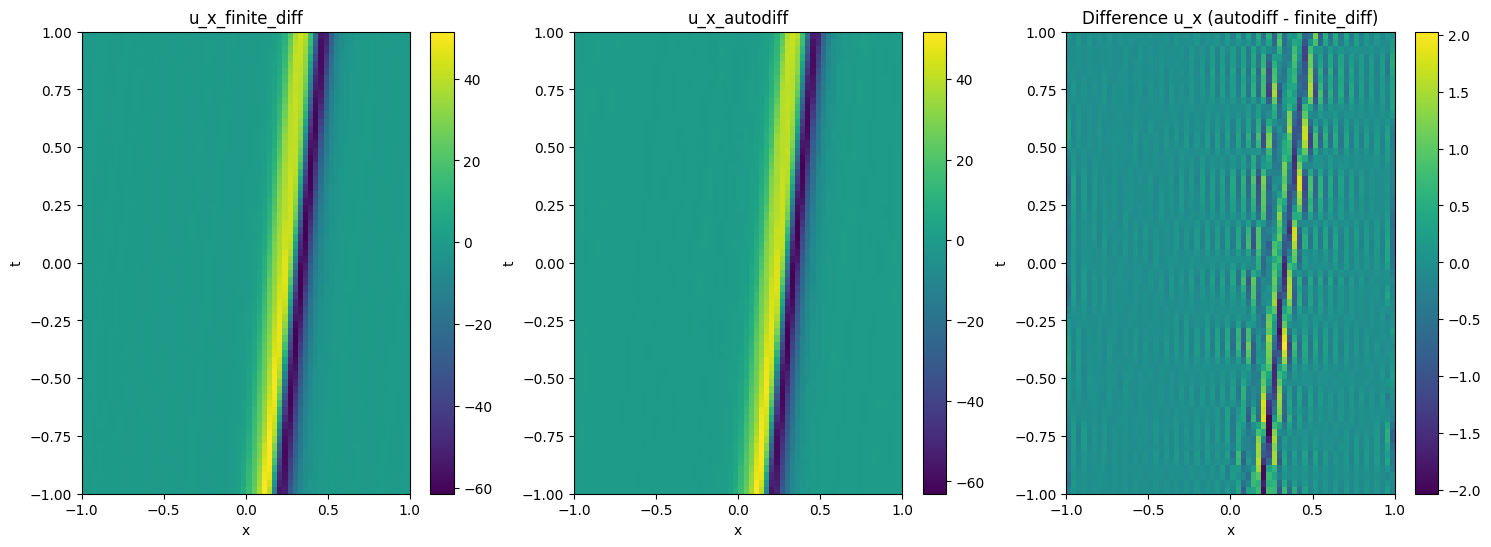

Largest difference in u_x: 2.0318130073186893


In [183]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot u_x_finite_diff
im1 = axes[0].imshow(u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x_train_s[0], x_train_s[-1], t_train_s[0], t_train_s[-1]], origin='lower')
axes[0].set_title('u_x_finite_diff')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
fig.colorbar(im1, ax=axes[0])

# Plot u_x_autodiff
im2 = axes[1].imshow(u_pred_x_rfft, aspect='auto', cmap='viridis', extent=[x_train_s[0], x_train_s[-1], t_train_s[0], t_train_s[-1]], origin='lower')
axes[1].set_title('u_x_autodiff')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
fig.colorbar(im2, ax=axes[1])

# Plot difference u_x
im3 = axes[2].imshow(u_pred_x_rfft - u_x_finite_diff, aspect='auto', cmap='viridis', extent=[x_train_s[0], x_train_s[-1], t_train_s[0], t_train_s[-1]], origin='lower')
axes[2].set_title('Difference u_x (autodiff - finite_diff)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
fig.colorbar(im3, ax=axes[2])

plt.show()

print("Largest difference in u_x:", jnp.max(jnp.abs(u_pred_x_rfft - u_x_finite_diff)))